# Exercise set 9

> *  The goal of the first part of the exercise is to gain familiarity with partial least
squares regression. For this, we will make
a model that can predict the concentrations in a mixture from near-infrared spectra.
> 
> * In the second part of the exercise, you will do a PCA analysis of gene expressions.
This part is to get more experience with PCA, particularly interpreting results from PCA.

## Exercise 9.1

[Windig and Stephenson](https://doi.org/10.1021/ac00046a015) measured near-infrared spectra
for 140 mixtures of the solvents methylene chloride, 2-butanol, methanol,
dichloropropane, and acetone.
We will here predict the compositions of the mixtures from the spectra.
Each spectrum was sampled at 700 wavelengths
between 1100 and 2500~nm. The file
[`Data/windig.csv`](Data/windig.csv) contains the raw data:
Each row in this file
contains a spectrum (the columns starting with `wavelength.`) and the
corresponding concentrations (the columns starting with `conc.`).

The data can be loaded as follows:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context("notebook")

data = pd.read_csv("Data/windig.csv")
X = data.filter(like="wavelength", axis=1).values  # NIR spectra
Y = data.filter(like="conc", axis=1).values  # Concentrations
print(f"No. of spectra: {X.shape[0]}")
print(f"No. of wavelengths: {X.shape[1]}")
print(f"No of concentration samples: {Y.shape[0]}")
print(f"No of species in each sample: {Y.shape[1]}")

No. of spectra: 140
No. of wavelengths: 700
No of concentration samples: 140
No of species in each sample: 5


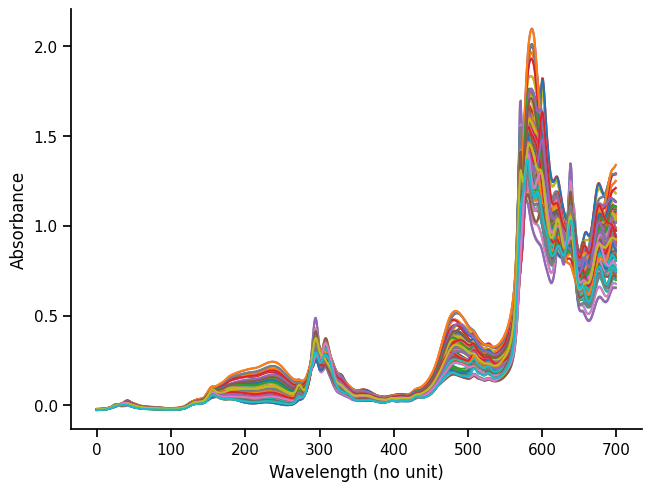

In [2]:
# To plot the spectra:
fig, ax = plt.subplots(constrained_layout=True)
for spectrum in X:
    ax.plot(spectrum)
ax.set(xlabel="Wavelength (no unit)", ylabel="Absorbance")
sns.despine(fig=fig)

### 9.1(a)
Create a partial least squares regression (PLSR) model for predicting
the concentrations. Use 1 PLS component for your first model and
assess it using $R^2$, RMSEC, RMSECV and RMSEP.  An example
of how this can be done are given below.

These values (RMSEC, RMSECV, and RMSEP) are all based on calculating the
root mean squared error (RMSE) given by,

\begin{equation}
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^N (y_i - \hat{y}_i)^2},
\tag{1}\end{equation}

where $y_i$ are our measured $y$-values and $\hat{y}_i$ are the
values predicted by our model. The difference between RMSEC,
RMSEP, and RMSECV lie in the part of the data we use to
calculate them. This is based on first splitting the data into
a *training* and *test* set, and then
performing what we call
[*cross-validation*](https://scikit-learn.org/stable/modules/cross_validation.html) using
the training set:


* When we use the training set to create our model, we are doing
  a *calibration*. If we calculate RMSE based on using
  the training set, we refer to this as the RMSEC (root mean squared
  error of calibration).
  This number
  quantifies the error we get in connection with making (calibrating)
  the model.
  
* When we use the test set to test our model, we are
  checking how well our model *predicts* "new" samples
  (that is, samples not used when making the model). If
  we calculate RMSE based on the training set, we refer to 
  this as the RMSEP (root mean squared error of prediction). This
  number quantifies the error we can expect to make when using
  our model for predicting new samples.
  
* Cross-validation is based on further splitting the training set. Typically, we divide the     training set into $k$ smaller subsamples, and we repeat the fitting of the
  model $k$ times. Each time we repeat the fitting, we retain a single
  subsample for validation, and we fit the model using
  the $k-1$ other subsamples. For the subsample we retained
  for validation, we can calculate the RMSE value of how
  well our model predicts it. Since we repeat this $k$ times,
  we can make it so that each of the $k$ subsamples is
  used exactly once for validation. Finally, we can
  obtain the average RMSE of the $k$ fittings, and we
  refer to this value as the RMSECV (root mean squared error
  of cross-validation). This number also estimates how well the model predicts new cases, and   we also get information on how sensitive the model is to model parameters and the part of   
  the training set used. We can also use cross-validation to optimize the parameters in the 
  model (for instance, the number of PLS components).

Luckily, methods for splitting our data into training and test
sets, calculating RMSE, and doing cross-validation are already
available in sklearn. Note: Splitting the data into training
and test sets and performing cross-validation involves some randomness, and your answers will probably change if you rerun
your code.

Here is a visualization of the splitting:
![cross](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [3]:
# First, here is how you can split into a testing and training set:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.33,  # Use 33 % of the data (one third) for the test set.
    shuffle=True,  # Randomly shuffle the data
)

In [4]:
# Make a PLS model:
from sklearn.cross_decomposition import PLSRegression

model = PLSRegression(n_components=4)  # Set up a PLS model with 4 components
model.fit(X_train, Y_train)  # Fit/make the model

PLSRegression(n_components=4)

In [5]:
# Calulate scores for the model:
from sklearn.metrics import r2_score, mean_squared_error

Y_hat_train = model.predict(X_train)  # Predict for the training set
Y_hat_test = model.predict(X_test)  # Predict for the test set

# Calculate R²:
r2_train = r2_score(Y_train, Y_hat_train)
print(f"R² for training set: {r2_train}")
r2_test = r2_score(Y_test, Y_hat_test)
print(f"R² for test set: {r2_test}")

# Calculate RMSE:
rmsec = mean_squared_error(Y_train, Y_hat_train, squared=False)
print(f"RMSEC: {rmsec}")
rmsep = mean_squared_error(Y_test, Y_hat_test, squared=False)
print(f"RMSEP: {rmsep}")

R² for training set: 0.9665701737589029
R² for test set: 0.9484565393138166
RMSEC: 1.8926291363535448
RMSEP: 2.279000340966563


In [6]:
# Example for cross-validation:
from sklearn.model_selection import cross_val_score

# Run cross-validation:
cvscore = cross_val_score(
    model,  # Select the model we are going to score
    X_train,  # Give the X-training set
    Y_train,  # Give the y-training set
    scoring="neg_mean_squared_error",  # select scoring method
    cv=5,  # Number of splits to make
)
# Note: the scoring is here "neg_mean_squared_error".
# This is the negative of the MSE!
# The cross_val_score method is often used in
# connection with optimization where we would like to
# maximize something, and the score can be used to pick
# the best value. Since we usually do not want to
# maximize the error, this method is made so that it
# calculates the negative of the error.

cvscore = np.sqrt(-cvscore)  # Account for the negative sign.
rmsecv = cvscore.mean()
rmsecv_std = np.std(cvscore)
print(f"\nRMSECV: {rmsecv} ± {rmsecv_std}")


RMSECV: 2.448979990625679 ± 0.3358758432720017


In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
# We start from the beginning:
# 1) Load the data:
data = pd.read_csv("Data/windig.csv")
X = data.filter(like="wavelength", axis=1).values  # NIR spectra
Y = data.filter(like="conc", axis=1).values  # Concentrations

# 2) Split the data and scale X:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, shuffle=True
)

scale_x = StandardScaler()
X_train = scale_x.fit_transform(X_train)
X_test = scale_x.transform(X_test)


# 3) Create PLS model:

model0 = PLSRegression(n_components=1)
model0.fit(X_train, Y_train)

PLSRegression(n_components=1)

In [9]:
# 4) Calculate the metrics for the model, here we create methods
# to do this, so that we can reuse the methods later.

def score_model(model, X_train, X_test, Y_train, Y_test):
    """Score a regression model."""
    Y_hat_train = model.predict(X_train)
    Y_hat_test = model.predict(X_test)
    scores = {
        "r²(train)": r2_score(Y_train, Y_hat_train),
        "r²(test)": r2_score(Y_test, Y_hat_test),
        "RMSEC": mean_squared_error(Y_train, Y_hat_train, squared=False),
        "RMSEP": mean_squared_error(Y_test, Y_hat_test, squared=False),
    }
    scores_cv = cross_val_score(
        model,
        X_train,
        Y_train,
        scoring="neg_mean_squared_error",
        cv=10,
    )
    scores_cv = np.sqrt(-scores_cv)
    scores["RMSECV"] = scores_cv.mean()
    scores["RMSECV_std"] = scores_cv.std()
    return scores


def score_models(models, X_train, X_test, Y_train, Y_test):
    """Score a set of models, and return a pandas DataFrame with results."""
    scores = {"PLS components": []}
    for model in models:
        scores["PLS components"].append(model.n_components)
        new_scores = score_model(model, X_train, X_test, Y_train, Y_test)
        for key, val in new_scores.items():
            if key not in scores:
                scores[key] = []
            scores[key].append(val)
    return pd.DataFrame(scores)


table0 = score_models([model0], X_train, X_test, Y_train, Y_test)

In [10]:
table0

,PLS components,r²(train),r²(test),RMSEC,RMSEP,RMSECV,RMSECV_std
0,1,0.247561,0.217065,10.486181,10.357689,10.725593,1.014146


#### Your answer to question 9.1(a): ($R^2$, RMSEC, RMSECV and RMSEP)

(See the table above.) 

### 9.1(b)
Improve your PLSR model by including more
PLS components.
Try components from 2 up to 15 and compare the different models. How many
PLS components are you satisfied with? 

In [11]:
models = []
for i in range(1, 16):
    modeli = PLSRegression(n_components=i)
    modeli.fit(X_train, Y_train)
    models.append(modeli)
    
table1 = score_models(models, X_train, X_test, Y_train, Y_test)

In [12]:
table1

,PLS components,r²(train),r²(test),RMSEC,RMSEP,RMSECV,RMSECV_std
0,1,0.247561,0.217065,10.486181,10.357689,10.725593,1.014146
1,2,0.498219,0.411449,8.035017,8.717968,8.595023,1.357544
2,3,0.740217,0.688404,5.134260,6.217709,6.089066,1.056330
3,4,0.951079,0.927082,2.217183,2.725591,2.672638,0.557942
4,5,0.992443,0.992558,1.036295,1.007494,1.124003,0.209824
5,6,0.994707,0.994910,0.850693,0.828306,0.967025,0.192171
6,7,0.996394,0.995974,0.719339,0.743748,0.809638,0.160612
7,8,0.997473,0.996744,0.599297,0.664198,0.693268,0.101526
8,9,0.997992,0.997303,0.521241,0.595802,0.631950,0.100489
9,10,0.998347,0.997953,0.461893,0.524710,0.579096,0.113684


In [13]:
from kneed import KneeLocator 

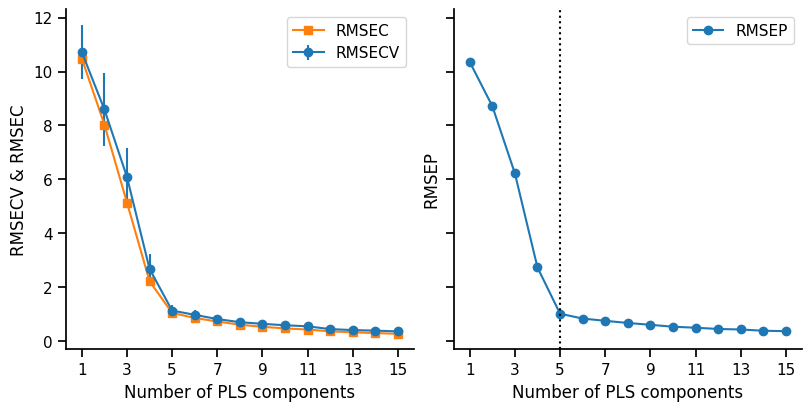

In [14]:
fig, axes = plt.subplots(constrained_layout=True,
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(8, 4),
)
axes[0].errorbar(
    table1["PLS components"],
    table1["RMSECV"],
    table1["RMSECV_std"],
    marker="o",
    label="RMSECV",
)
axes[0].plot(
    table1["PLS components"], table1["RMSEC"], marker="s", label="RMSEC"
)
axes[1].plot(
    table1["PLS components"], table1["RMSEP"], marker="o", label="RMSEP"
)
for ax in axes:
    ax.set(xlabel="Number of PLS components")
    ax.set_xticks(table1["PLS components"][::2])
    ax.legend()
axes[0].set(ylabel="RMSECV & RMSEC")
axes[1].set(ylabel="RMSEP")

kneedle = KneeLocator(
    table1["PLS components"],
    table1["RMSEP"],
    S=1.0,
    curve="convex",
    direction="decreasing",
)
axes[1].axvline(
    x=kneedle.elbow,
    ls=":",
    label=f"Elbow ({kneedle.elbow} components)",
    color="k",
)


sns.despine(fig=fig)

#### Your answer to question 9.1(b):

The figure above shows how the RMSE values change with the number of components.
When increasing the number of components, we improve the model (we make the RMSE values smaller). However, we prefer a model with relatively few components (to avoid over-fitting), and we are satisfied with using just five here. This is motivated by the large drops in RMSECV and RMSEP observed up to five PLS components; including more than five components will only give minor improvements.

### 9.1(c)
Plot the regression coefficients for the model you found in [9.1(b)](#9.1(b)).

In [15]:
# You can get the regression coefficients with:
B = model.coef_
# To get the coefficients for solvent no. i, you can do:
# B[:, i]  # this selects all rows for column i.

/home/andersle/opt/pyenv/py3.11/lib64/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


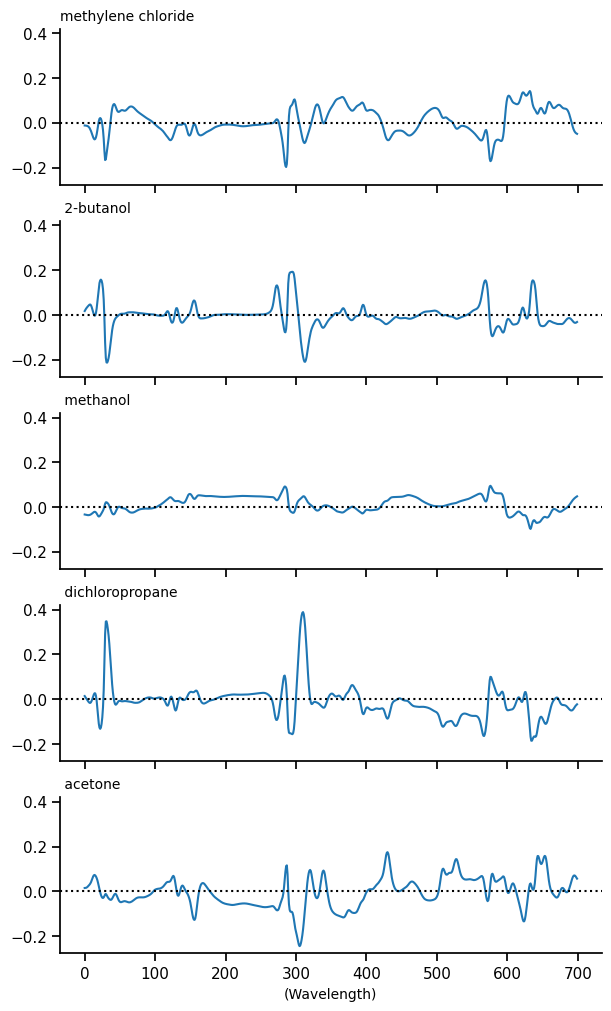

In [16]:
# Your code here
B = models[4].coef_  # Model with 5 components
fig, axes = plt.subplots(
    constrained_layout=True, nrows=5,
    sharey=True, sharex=True,
    figsize=(6, 10)
)
solvents = "methylene chloride, 2-butanol, methanol, dichloropropane, acetone".split(",")
for i, solvent in enumerate(solvents):
    axes[i].set_title(solvent, loc="left", fontsize="small")
    #axes[i].set(ylabel="Coefficient value", xlabel="Wavelength")
    axes[i].plot(B[:, i])
    axes[i].axhline(y=0, ls=":", color="k")
axes[-1].set_xlabel("(Wavelength)", fontsize="small")
sns.despine(fig=fig)

#### Your answer to question 9.1(c):
(See the figure above.)

The regression coefficients show some resemblance to spectra and  they pick out different
parts as being important for the prediction of the different concentrations.

### 9.1(d)
Optimize the number of PLS components by a cross-validated grid search of the number of
PLS components. Is this optimized model different from the PLS model you found in [9.1(b)](#9.1(b))?

In [17]:
# Here is the code for running the optimalization. This will try out
# the number of PLS components and score the model with cross validation.
from sklearn.model_selection import GridSearchCV

# First, we define a range of PLS components to try, let us
# do 1, 2, ..., 20, 25, 50, 75, 100:
parameters = {
    "n_components": list(range(1, 20)) + [25, 50, 75, 100]
}

grid = GridSearchCV(
    PLSRegression(),  # the model we will make
    parameters,  # the parameters to investigate
    cv=5,  # number of splits for cross-validation
    scoring="r2",  # select the model with highest R²
    refit=True,  # refit the best model for the whole training set
)
grid.fit(X_train, Y_train)

/home/andersle/opt/pyenv/py3.11/lib64/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 73
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/andersle/opt/pyenv/py3.11/lib64/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 73
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/andersle/opt/pyenv/py3.11/lib64/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 73
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/andersle/opt/pyenv/py3.11/lib64/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 74
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/andersle/opt/pyenv/py3.11/lib64/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is const

GridSearchCV(cv=5, estimator=PLSRegression(),
             param_grid={'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 25, 50,
                                          75, 100]},
             scoring='r2')

In [18]:
# The best estimator us:
grid.best_estimator_

PLSRegression(n_components=75)

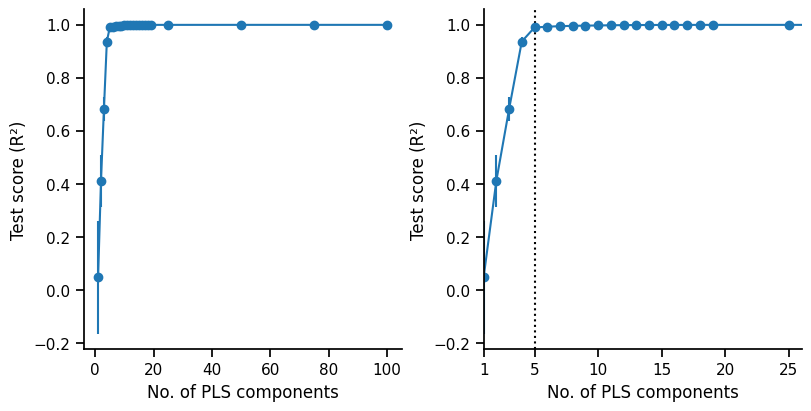

In [19]:
# It is also a good idea to plot the scores to see where it levels off:
fig, axes = plt.subplots(constrained_layout=True, ncols=2, figsize=(8, 4))
for ax in axes:
    ax.errorbar(
        parameters["n_components"],
        grid.cv_results_["mean_test_score"],
        yerr=grid.cv_results_["std_test_score"],
        marker="o",
    )
    ax.set(xlabel="No. of PLS components", ylabel="Test score (R²)")
axes[1].set_xlim(1, 26)
axes[1].set_xticks([1, 5, 10, 15, 20, 25])
axes[1].axvline(x=5, ls=":", color="k")
sns.despine(fig=fig)
# Hint: It may be a good idea to zoom in on the part (1, 20) for the x-axis:

#### Your answer to question 9.1(d):

The grid search method selects 25 components (note: this number might change every time you run the code above due to some randomness in the splitting). In the figure above, there is not a big difference in the score beyond five components. So even though the method selects 25 components, I will pick five because the score for 25 and five is essentially the same.

### 9.1(e)
Assume that you are given a spectrum from a mixture with unknown concentrations of the solvents. How well would your model
predict the unknown concentrations?

In [20]:
# Get the RMSEP values for the model with five components:
Y_hat_test = models[4].predict(X_test)

for i, solvent in enumerate(solvents):
    rmsep = mean_squared_error(Y_test[:, i], Y_hat_test[:, i], squared=False)
    print(f"RMSEP {solvent}: {rmsep:.3g}")

RMSEP methylene chloride: 0.928
RMSEP  2-butanol: 0.948
RMSEP  methanol: 0.837
RMSEP  dichloropropane: 1.22
RMSEP  acetone: 1.11


#### Your answer to question 9.1(e):

The RMSEP values indicate the error we can expect to make when predicting new samples. In all cases, these values (see the output above) are around one concentration unit.

### 9.1(f)
Create a least squares model for predicting the concentrations.
Assess it using $R^2$, RMSEC, RMSECV and RMSEP. Does this model
perform as you expect?

In [21]:
# Your code here
from sklearn.linear_model import LinearRegression

model_ls = LinearRegression()
model_ls.fit(X_train, Y_train)

LinearRegression()

In [22]:
table2 = score_model(model_ls, X_train, X_test, Y_train, Y_test)
table2

{'r²(train)': 1.0,
 'r²(test)': 0.9997162831020479,
 'RMSEC': 7.624066429493728e-14,
 'RMSEP': 0.19504582641079765,
 'RMSECV': 0.25565003673266196,
 'RMSECV_std': 0.051912907380122005}

#### Your answer to question 9.1(f):

The least squares model is preforming well. In this situation,
we fit a data set with 140 samples using 700 variables, which we can do
perfectly. Judging from the training set, the performance is about the
same, so this does not immediately suggest that we have overfitted the model.

But let us see what happens if we, by some experimental mistake, have shifted the
spectrum two wavelengths to the right for the test set:

In [23]:
X_test_shift = np.roll(X_test, 2, axis=1)

Y_hat_ls = model_ls.predict(X_test_shift)
Y_hat_pls = models[4].predict(X_test_shift)

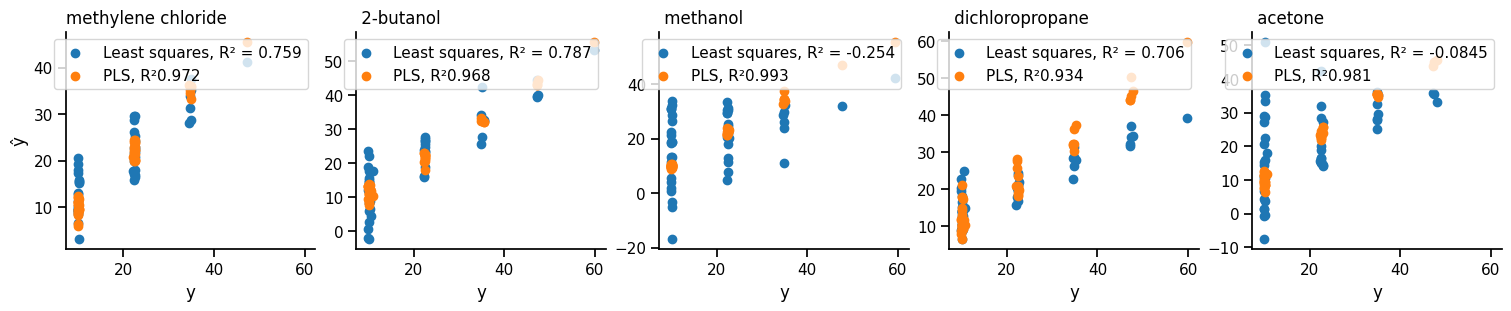

In [24]:
fig, axes = plt.subplots(constrained_layout=True, ncols=5, figsize=(15,3), sharex=True)
for i, solvent in enumerate(solvents):
    axes[i].set_title(solvent, loc="left")
    r2_ls = r2_score(Y_test[:, i], Y_hat_ls[:, i])
    r2_pls = r2_score(Y_test[:, i], Y_hat_pls[:, i])
    axes[i].scatter(Y_test[:, i], Y_hat_ls[:, i], label=f"Least squares, R² = {r2_ls:.3g}")
    axes[i].scatter(Y_test[:, i], Y_hat_pls[:, i], label=f"PLS, R²{r2_pls:.3g}")
    axes[i].set_xlabel("y")
    axes[i].legend()
axes[0].set_ylabel("ŷ")
sns.despine(fig)

The figure above shows the measured (y) and predicted (ŷ) values for the least squares and the PLS model with five compoents, when
applied to the shifted spectra. Here, the effect is larger for the least squares model.
This can indicate that the least squares model is overfitted, and it is not so robust to
small changes in the measured spectra.

## Exercise 9.2

[Schummer *et al.*](https://doi.org/10.1016/S0378-1119(99)00342-X) studied ovarian cancer by measuring gene expression values for 1536 genes in both normal and cancer tissues. One of their goals was to investigate if specific genes were overexpressed in cancer samples compared with normal samples.
This knowledge may be used for diagnosis, and we will here see if we
can find such genes by performing a PCA. The raw data can be
found in the file [`Data/ovo.csv`](Data/ovo.csv).
Each row in the data file contains a tissue sample's gene expressions (for 1536 genes). Each column corresponds to a specific gene, named `X.1`, `X.2`, and so on.
The classification of tissue as normal (`N`) or cancer (`C`) can
be found in the column `class`. The data can be loaded with:

In [25]:
"""Load the data set."""
import pandas as pd

data = pd.read_csv("Data/ovo.csv")
classes = data["class"]  # Classification of samples.
X = data.filter(like="X.", axis=1)  # Gene expressions for samples.

### 9.2(a)

Perform a principal component analysis (PCA) on the gene expression data and plot the
explained variance as a function of the number of components.

Center the data before performing the PCA. This can be
done as follows with the `scale` method
from `sklearn.preprocessing`: `X = scale(X, with_std=False)`.
Here, all the variables are in the same units, so we do not need
to scale the variance (we set `with_std=False`).

In [26]:
from sklearn.preprocessing import scale
X = scale(X, with_std=False)

In [27]:
from sklearn.decomposition import PCA

pca = PCA()
scores = pca.fit_transform(X)

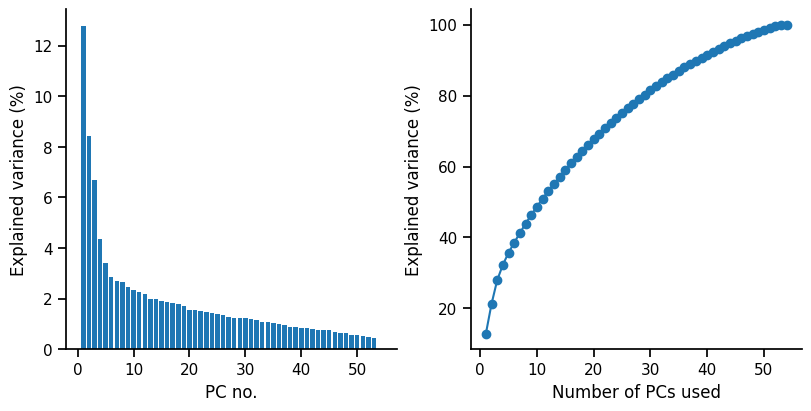

In [28]:
fig, (ax1, ax2) = plt.subplots(constrained_layout=True, ncols=2, figsize=(8, 4))
comp = range(1, len(pca.explained_variance_ratio_)+1)
ax1.bar(comp, 100*pca.explained_variance_ratio_)
ax2.plot(comp, 100*np.cumsum(pca.explained_variance_ratio_), marker="o")
ax1.set(xlabel="PC no.", ylabel="Explained variance (%)")
ax2.set(xlabel="Number of PCs used", ylabel="Explained variance (%)")
sns.despine(fig=fig)

#### Your answer to question 9.2(a):

The explained variance per component and the cumulative variance explained is
shown in the figure above.

### 9.2(b)
Inspect the data by plotting the scores and loadings for
principal component
number 1 and principal component number 2:


* (i) Can you observe any clustering
  of the samples? Here, it may be helpful to colour the samples
  according to their classification as normal or cancer.


* (ii) Are there any outliers among the samples?


* (iii) Can you identify some
  genes which are overexpressed in tumors? 


* (iv) Can you identify some
  genes which are underexpressed in tumors? 

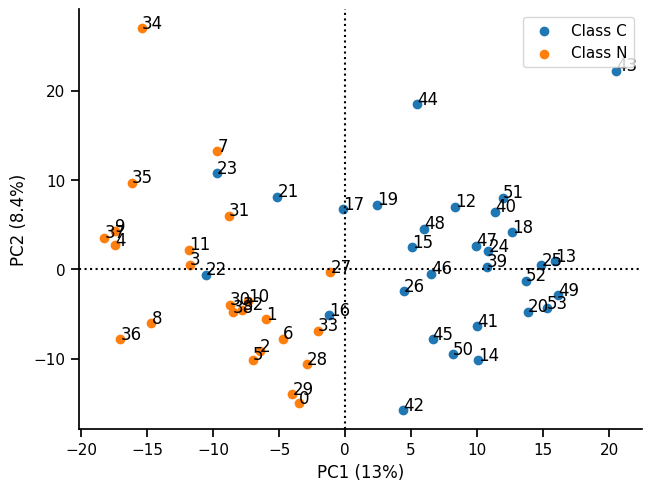

In [29]:
# First the scores:
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(x=scores[classes=="C", 0], y=scores[classes=="C", 1], label="Class C")
ax.scatter(x=scores[classes=="N", 0], y=scores[classes=="N", 1], label="Class N")
for i, pos in enumerate(scores):
    ax.text(pos[0], pos[1], f"{i}")
ax.legend()
var1 = pca.explained_variance_ratio_[0] * 100
var2 = pca.explained_variance_ratio_[1] * 100
ax.set(
    xlabel=f"PC1 ({var1:.2g}%)",
    ylabel=f"PC2 ({var2:.2g}%)",
)
ax.axhline(y=0, ls=":", color="k")
ax.axvline(x=0, ls=":", color="k")

sns.despine(fig=fig)

10 largest along PC1: [1124 1306 1525  364 1159  692   92 1116  538 1490]


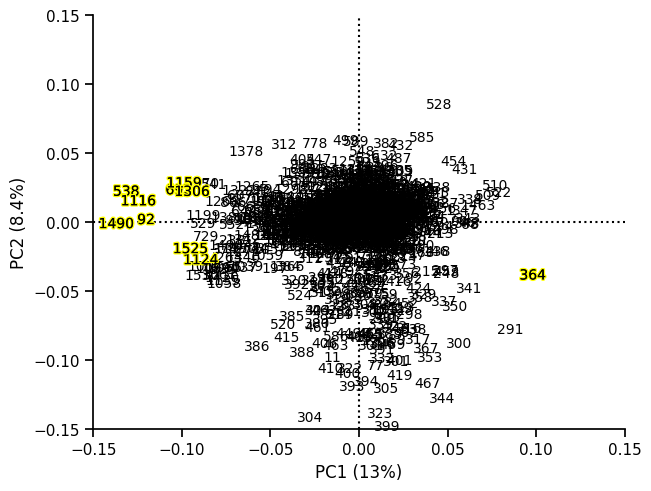

In [30]:
# And then the loadings:
import matplotlib.patheffects as pe
fig, ax = plt.subplots(constrained_layout=True)
loadings = pca.components_
var1 = pca.explained_variance_ratio_[0] * 100
var2 = pca.explained_variance_ratio_[1] * 100
ax.set(
    xlabel=f"PC1 ({var1:.2g}%)",
    ylabel=f"PC2 ({var2:.2g}%)",
)
ax.axhline(y=0, ls=":", color="k")
ax.axvline(x=0, ls=":", color="k")
load1 = loadings[0, :]
load2 = loadings[1, :]

# Get the 10 largest loadings along PC1
idx = np.argsort(abs(load1))[-10:]
print(f"10 largest along PC1: {idx}")
for i, (xi, yi) in enumerate(zip(load1, load2)):
    txt = ax.text(xi, yi, i, fontsize="small", ha="center", va="center")
    if i in idx:  # If one of the 10 larges, add some yellow color:
        txt.set_path_effects(
                [
                    pe.withStroke(linewidth=2, foreground="yellow"),
                    pe.Normal(),
                ]
            )

ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.15, 0.15)
sns.despine(fig=fig)

#### Your answer to question 9.2(b):

> * (i) Can you observe any clustering
>  of the samples? Here, it may be helpful to colour the samples
>  according to their classification as normal or cancer.

We see some clustering into two groups (along PC1) with cancer and normal samples.
We note that there is some overlap between the two clusters, in particular for samples
16, 21, 22, and 23.


> * (ii) Are there any outliers among the samples?

Samples 34, 44 and 43 are separated from the other points. These could
be outliers. To investigate this
further, we plot the diagonal elements of the leverage matrix
($\mathbf{H}$) for the individual points (see page 212 in the textbook). 
The leverage matrix is
found from the scores $\mathbf{T}$,

\begin{equation*}
 \mathbf{H} = \mathbf{T} (\mathbf{T}^\top \mathbf{T})^{-1} \mathbf{T}^\top.
\end{equation*}
                    
The leverages for our samples are shown in the figure below:

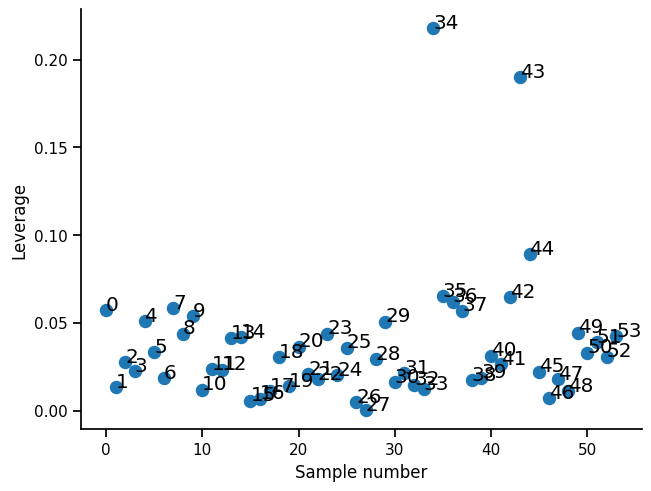

In [31]:
# Since we are looking at just two components, we should compute the
# leverage for the components we are actually using:
pca2 = PCA(n_components=2)
scores = pca2.fit_transform(X)
mat_inv = np.linalg.inv(np.dot(scores.T, scores))
leverage = np.dot(np.dot(scores, mat_inv), scores.T)
diag1 = np.diag(leverage)
fig, ax1 = plt.subplots(constrained_layout=True)
ax1.scatter(range(len(diag1)), diag1, s=75)
for i, diag1i in enumerate(diag1):
    ax1.annotate(i, (i, diag1i), fontsize="large")
ax1.set(xlabel="Sample number", ylabel="Leverage")
sns.despine(ax=ax1)

In this plot, the leverage is relatively high for samples 34 and
43, and this strengthens our suspicion that these points are outliers.
We need more information to know whether they are genuine
outliers or interesting samples.
We will thus keep all points in the following, but in a real-life situation,
we would investigate these two points further. We would also probably explore the points that overlap in more detail - the cancer samples 16, 21, 22, and 23 that
are "in-between" the N-samples.

>* (iii) Can you identify some
>  genes which are overexpressed in tumors? 

From the plot of the loadings, we find that the 5 genes with the largest expression for
the cancer samples (along PC1) are 364, 291, 522, 510, and 509.


>* (iv) Can you identify some
>  genes which are underexpressed in tumors? 

From the plot of the loadings, we find that the 5 genes with the lowest expression for
the cancer samples (along PC1) are 1490, 538, 1116, 92, and 692.

### 9.2(c)
Based on your answer in [9.2(b)](#9.2(b)), can
you identify some pairs of genes that seem to distinguish between
normal and tumor tissues? Support your findings by plotting the raw data.

In [32]:
# We make a small function to investigate pairs of genes:

from ipywidgets import interact, Dropdown


def show_data2(variable_x, variable_y):
    grid = sns.jointplot(
        data=data,
        x=f"X.{variable_x+1}",
        y=f"X.{variable_y+1}",
        hue="class",
        palette="muted",
    )
    ax = grid.fig.axes[0]
    ax.set_xlabel(f"Gene expression for {variable_x}")
    ax.set_ylabel(f"Gene expression for {variable_y}")
    
variables = sorted([364, 291, 522, 510, 509, 1490, 538, 1116, 92, 692])
    
dropdown1 = Dropdown(options=variables, description="Gene (x-axis):")
dropdown2 = Dropdown(options=variables, description="Gene (y-axis):")
interact(show_data2, variable_x=dropdown1, variable_y=dropdown2)

interactive(children=(Dropdown(description='Gene (x-axis):', options=(92, 291, 364, 509, 510, 522, 538, 692, 1…

<function __main__.show_data2(variable_x, variable_y)>

#### Your answer to question 9.2(c):

In the previous point, we found that the genes 364, 291, 522, 510, and 509 were overexpressed in cancer samples and that 1490, 538, 1116, 92, and 692 were underexpressed. After exploring
a bit with the figure above, we find that, for instance, genes 92 and 509 can be used
to separate the classes.